## IMA205 Challenge 2025 - Left Ventricle Segmentation
**Pedro de Almeida Marim**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib


In [2]:
from segmentation import compute_seed
from segmentation import compute_seed_hist_matching
from segmentation import compute_seed_equalization
from segmentation import compute_seeds
from segmentation import compute_seeds_radii_adapt

from segmentation import plot_heart_slice_with_seed
from segmentation import plot_heart_slice_with_circles

from segmentation import select_lowest_circle
from segmentation import normalize_image

from segmentation import region_growing_from_seed
from segmentation import abs_threshold_region_growing
from segmentation import compensate_coil_sensitivity
from segmentation import estimate_myocardium_mean


##### Left Ventricle Segmentation

**I. Seed Point Estimation**

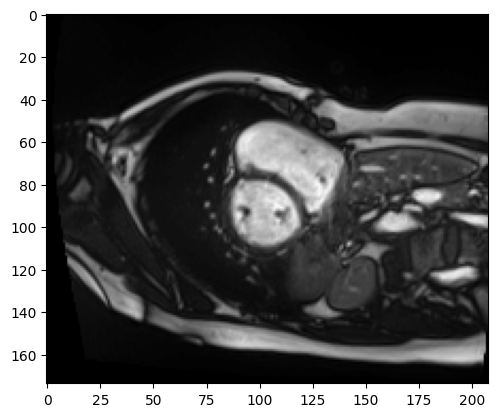

In [3]:
img_ED = nib.load('Dataset/Test/102/102_ED.nii')
img_ES = nib.load('Dataset/Test/102/102_ES.nii')
data_ED = img_ED.get_fdata()
data_ES = img_ES.get_fdata()

plt.imshow(data_ED[:, :, 4], cmap='gray');

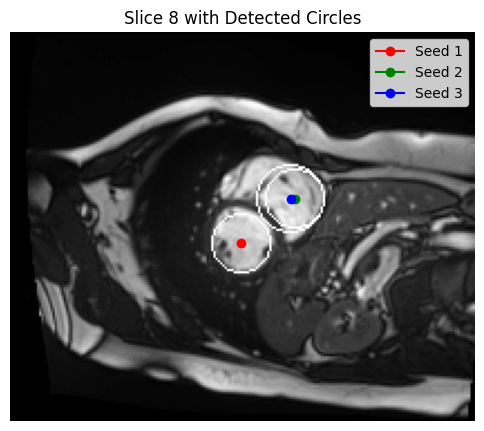

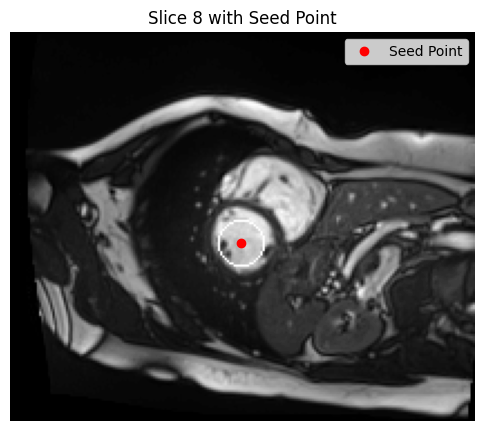

In [4]:
slice_idx, circles = compute_seeds(data_ED, data_ES)
plot_heart_slice_with_circles(data_ED, slice_idx, circles)
seed = select_lowest_circle(circles)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, 10)

**II. Mean and Standard Deviation of Blood Signal Estimation**

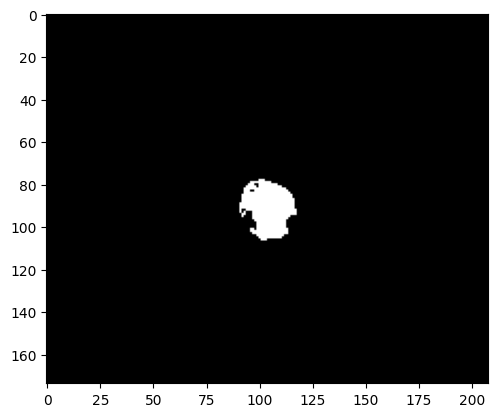

In [5]:
slice_img = data_ED[:, :, slice_idx]

max_diff = 30
mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = 30)

while leaked:
    max_diff -= 5
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = max_diff)
    if max_diff < 10:
        break

plt.imshow(mask, cmap='gray');

**III. Coil-Sensitivity Compensation**

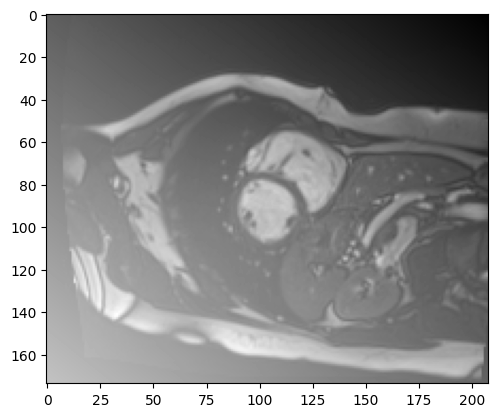

In [6]:
corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
corrected_slice = normalize_image(corrected_slice)
plt.imshow(corrected_slice, cmap='gray');

**IV. Myocardium Signal Intensity Estimation**

Thresholds list: [0, 30, 35, 40, 45, 50]
Mask 1 volume: 1


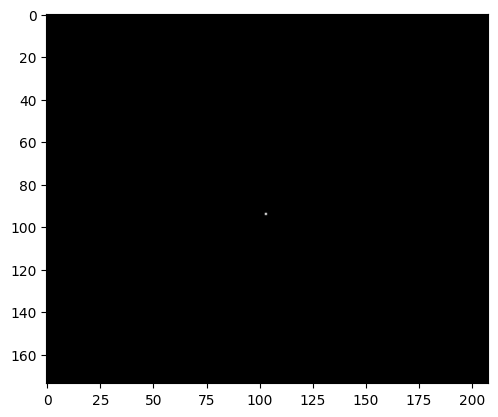

Mask 2 volume: 550


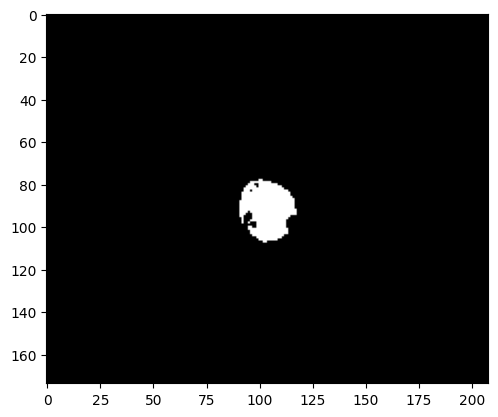

Mask 3 volume: 584


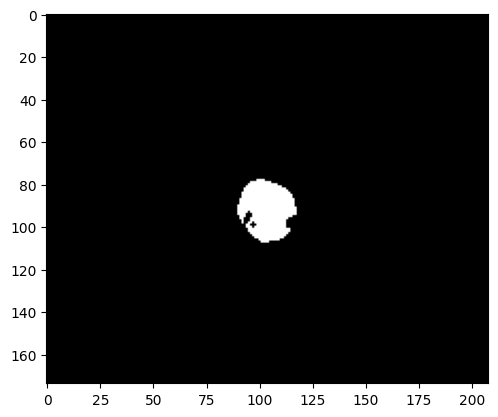

Mask 4 volume: 609


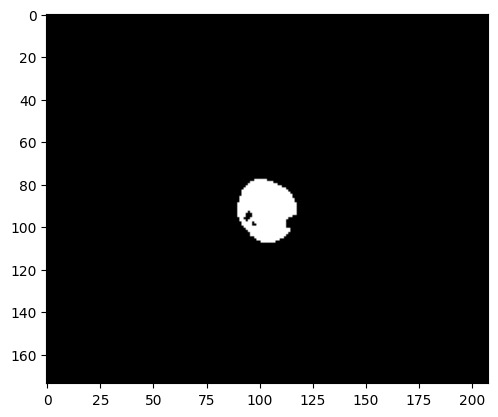

Mask 5 volume: 646


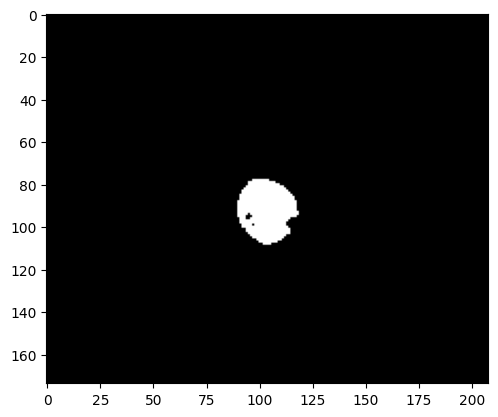

Exploded! Region too large
Mask 6 volume: 3037


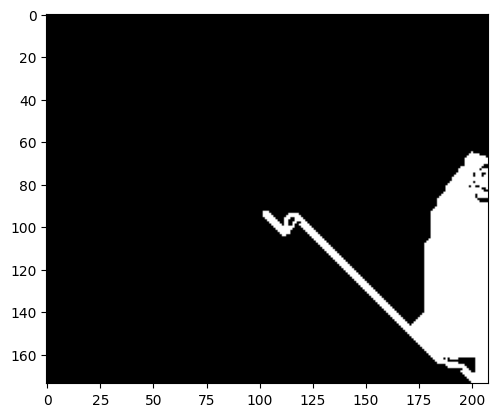

Leaked!


In [7]:
thresholds = [0, 30]
for i in range(2, 6):
    thresholds.append(thresholds[i-1] + 5)

print("Thresholds list:", thresholds)
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds, plot=True)

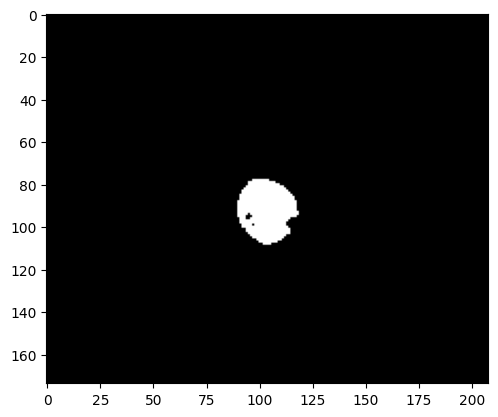

In [8]:
plt.imshow(lv_mask, cmap='gray');

**V. Left Ventricle Segmeentation**

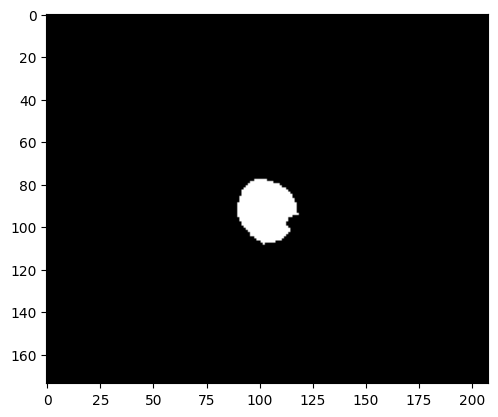

In [9]:
mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)
plt.imshow(mask, cmap='gray')
plt.show()

-----

##### Putting everything togheter

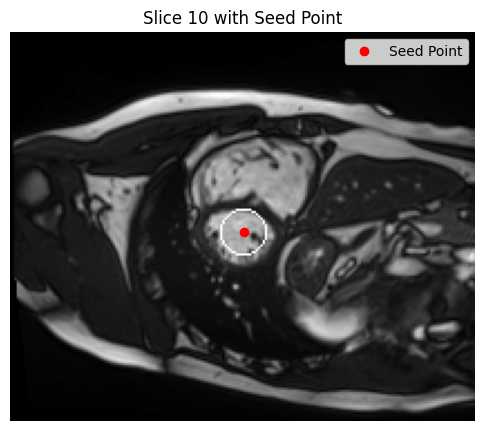

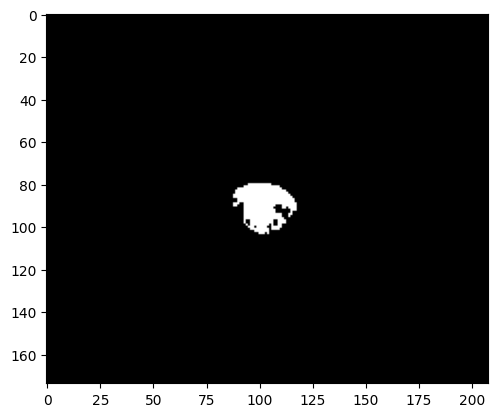

Mask 1 volume: 1


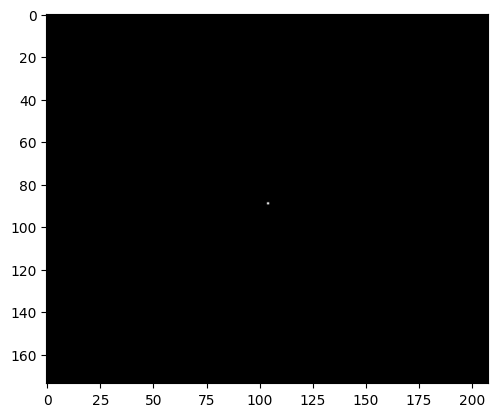

Mask 2 volume: 320


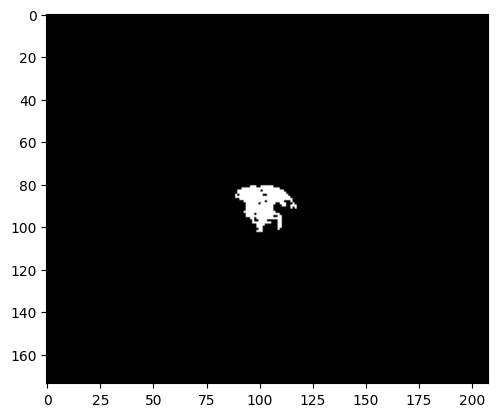

Mask 3 volume: 355


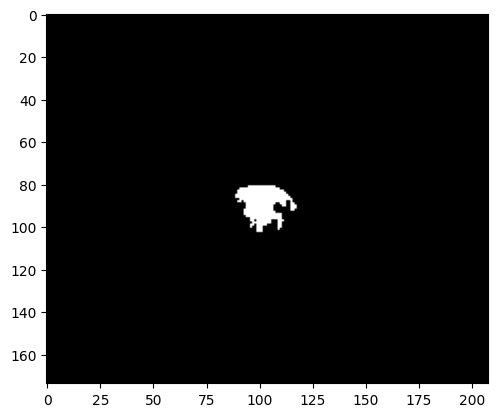

Mask 4 volume: 391


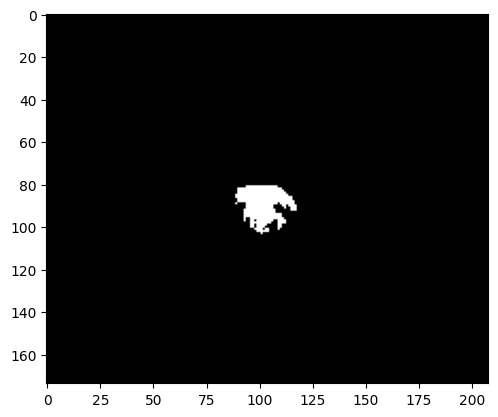

Mask 5 volume: 456


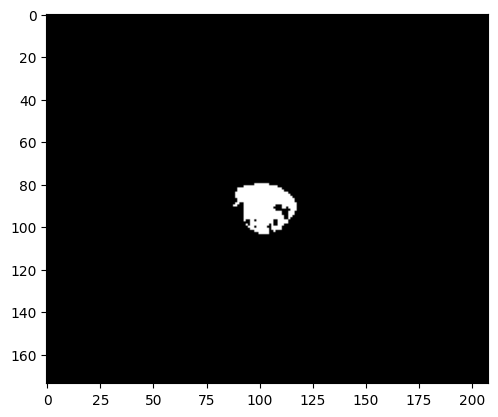

Mask 6 volume: 508


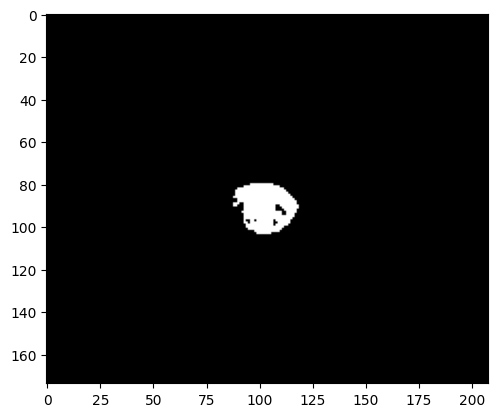

Mask 7 volume: 545


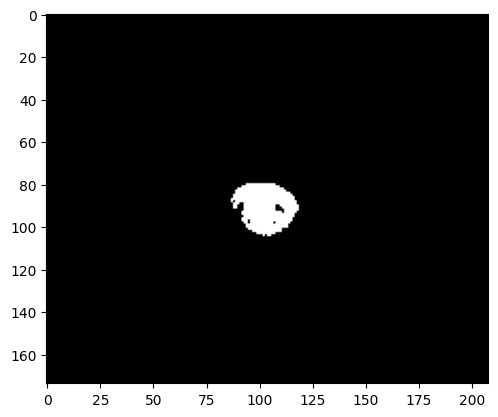

Mask 8 volume: 601


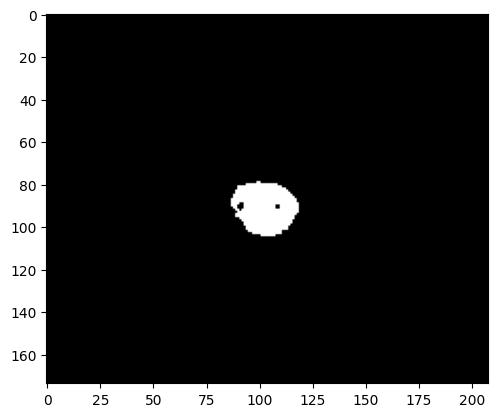

Exploded! Region too large
Mask 9 volume: 3151


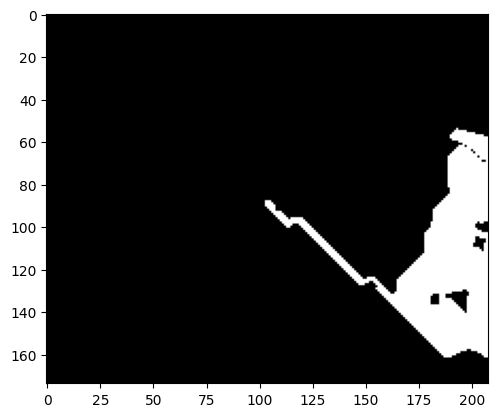

Leaked!


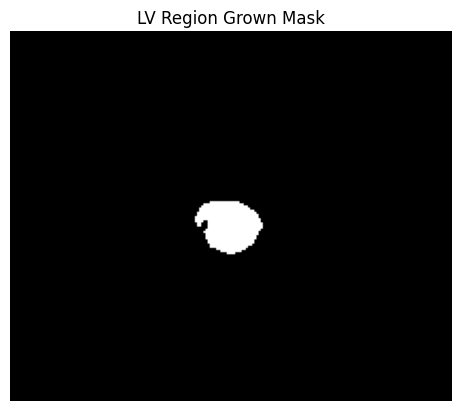

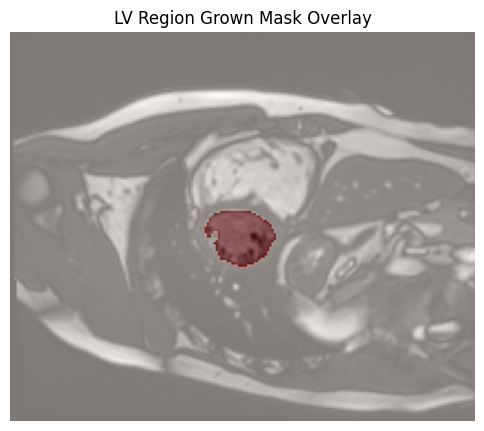

In [10]:
img_ED = nib.load('Dataset/Test/118/118_ED.nii')
img_ES = nib.load('Dataset/Test/118/118_ES.nii')
data_ED = img_ED.get_fdata()
data_ES = img_ES.get_fdata()

slice_idx, circles = compute_seeds(data_ED, data_ES)
seed = select_lowest_circle(circles)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, 10)

slice_img = data_ED[:, :, slice_idx]
max_diff = 30
mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = 30)
while leaked:
    max_diff -= 5
    if max_diff < 0:
        break
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = max_diff)
    
plt.imshow(mask, cmap='gray')
plt.show()

corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
corrected_slice = normalize_image(corrected_slice)

thresholds = [0, 10]
for i in range(2, 10):
    thresholds.append(thresholds[i-1] + 5)
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds, plot=True)

mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)

num_slices = data_ED.shape[2]
all_masks = [None] * num_slices
all_masks[slice_idx] = mask

plt.imshow(mask, cmap='gray')
plt.title("LV Region Grown Mask")
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(slice_img, cmap='gray')  
plt.imshow(mask, cmap='Reds', alpha=0.5)  
plt.title("LV Region Grown Mask Overlay")
plt.axis('off')
plt.show()

In [11]:
def lv_segmentation(slice_img, seed, print_=False, plot=False):
    """
    Segment the LV region from the slice image using region growing and adaptive histogram equalization.

    Parameters:
    - slice_img: 2D numpy array representing the slice image.
    - seed: tuple of (x, y) coordinates for the seed point.

    Returns:
    - lv_mask: 2D numpy array representing the LV mask.
    - lv_mean: mean intensity of the LV region.
    - lv_std: standard deviation of the LV region.
    - myoc_mean: mean intensity of the myocardium region.
    - myoc_std: standard deviation of the myocardium region.
    """
    # Perform region growing from seed
    max_diff = 30
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff=max_diff, print_=print_)
    
    while leaked:
        max_diff -= 5
        if max_diff < 0:
            break
        mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff=max_diff, print_=print_)

    # Compensate coil sensitivity and normalize image
    corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
    corrected_slice = normalize_image(corrected_slice)

    # Define thresholds
    thresholds = [0, 10]
    for i in range(2, 10):
        thresholds.append(thresholds[i-1] + 5)

    # Estimate myocardium mean and std using adaptive histogram equalization
    lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds, plot)

    # Apply absolute thresholding to obtain final LV mask
    final_lv_mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean + lv_std)

    return final_lv_mask

----

In [12]:
from scipy.ndimage import center_of_mass

def propagate_seed_recursive(data, index, last_index, current_mask, all_masks, plot=False):
    """
    Recursively propagate seed point to adjacent slices using energy-based seed estimation.

    Args:
        data: 3D numpy array (H, W, S)
        index: target slice index to compute seed for
        last_index: previous slice index that provided current_mask
        current_mask: binary mask of LV from the previous slice
        all_seeds: dictionary {slice_index: (x, y)} storing propagated seeds
        max_diff: used in energy computation for consistency

    Returns:
        Updated all_seeds dictionary with new seeds
    """
    # Boundary checks
    
    if index < 0 or index >= data.shape[2]:
        return 
    
    if plot:
        print("Processing slice index:", index)

    slice_prev = data[:, :, last_index]
    slice_curr = data[:, :, index]

    mu_prev = slice_prev[current_mask].mean()
    sigma_prev = slice_prev[current_mask].std()
    cog = center_of_mass(current_mask)
    cx, cy = int(cog[1]), int(cog[0])

    half_w = 5  # for 11x11 window
    window = []
    energies = []

    for dy in range(-half_w, half_w + 1):
        for dx in range(-half_w, half_w + 1):
            x, y = cx + dx, cy + dy
            if 0 <= x < slice_curr.shape[1] and 0 <= y < slice_curr.shape[0]:
                dist_term = ((np.sqrt((2 * sigma_prev) / (11 - 1)) * np.linalg.norm([cx - x, cy - y])) ** 2)
                intensity_term = (slice_curr[y, x] - mu_prev) ** 2
                energy = dist_term + intensity_term
                energies.append(energy)
                window.append((x, y))

    if not energies:
        return   # no valid window

    min_idx = np.argmin(energies)
    best_seed = window[min_idx]

    mask = lv_segmentation(slice_curr, best_seed, plot=plot) 

    all_masks[index] = mask

    # Recursive call in same direction
    if index > last_index:
        return propagate_seed_recursive(data, index + 1, index, mask, all_masks)
    else:
        return propagate_seed_recursive(data, index - 1, index, mask, all_masks)


In [13]:
propagate_seed_recursive(data_ED, slice_idx + 1, slice_idx, all_masks[slice_idx], all_masks)
propagate_seed_recursive(data_ED, slice_idx - 1, slice_idx, all_masks[slice_idx], all_masks)

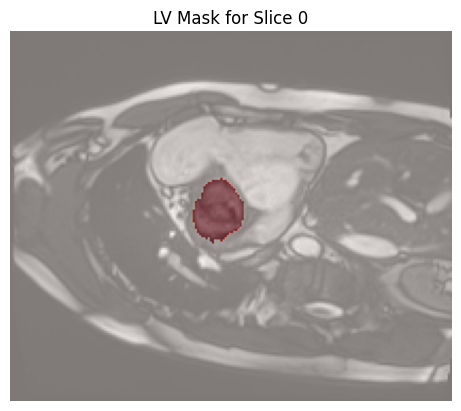

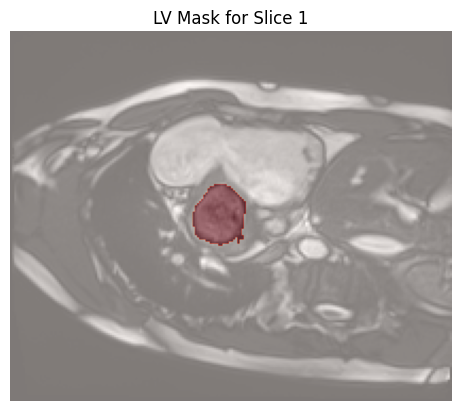

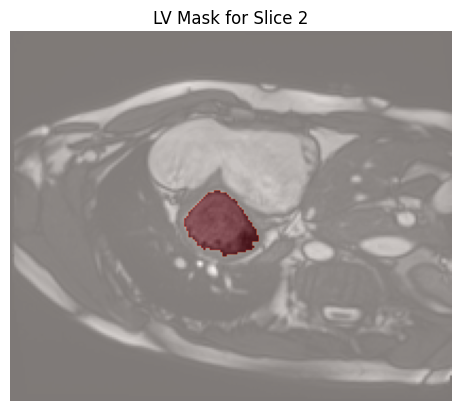

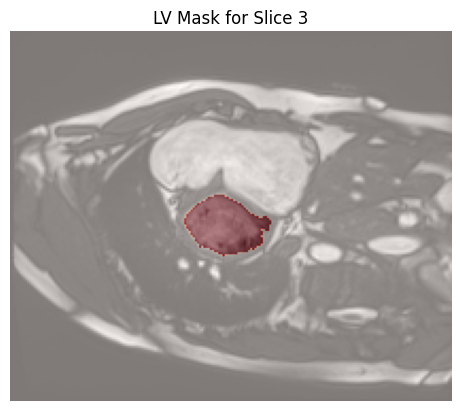

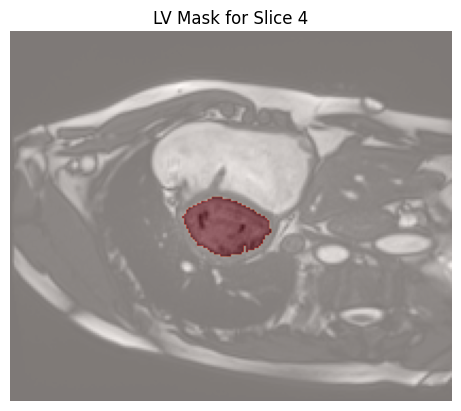

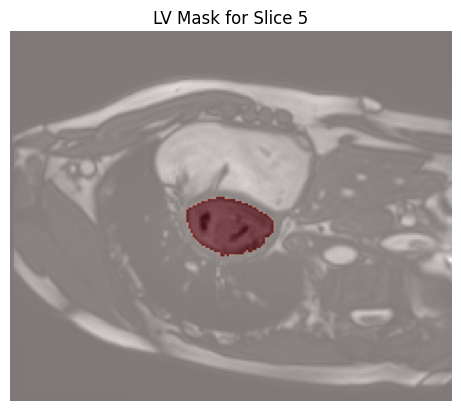

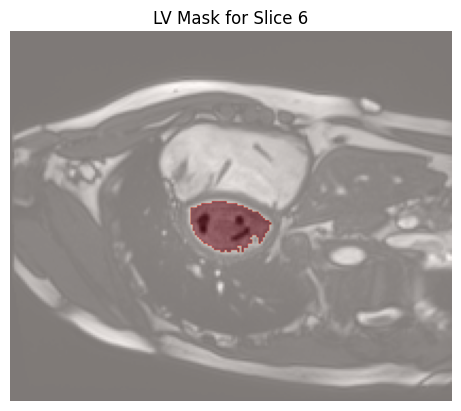

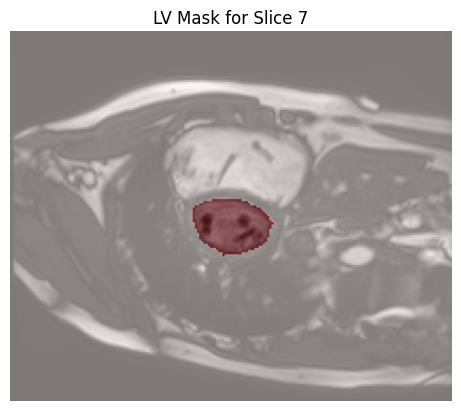

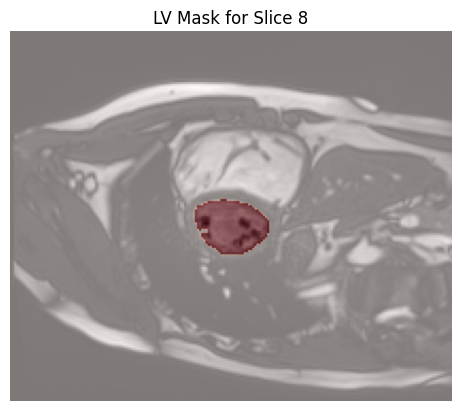

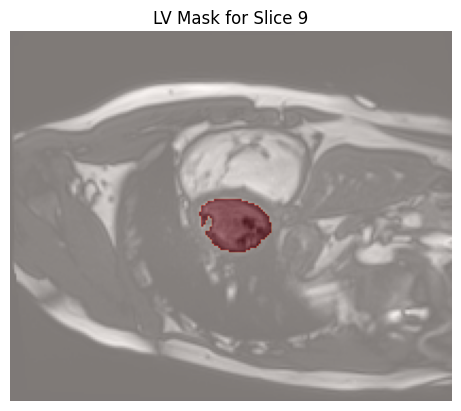

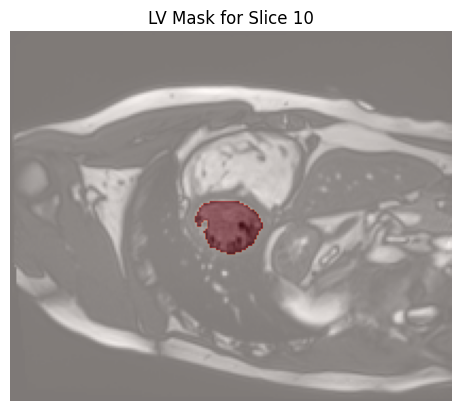

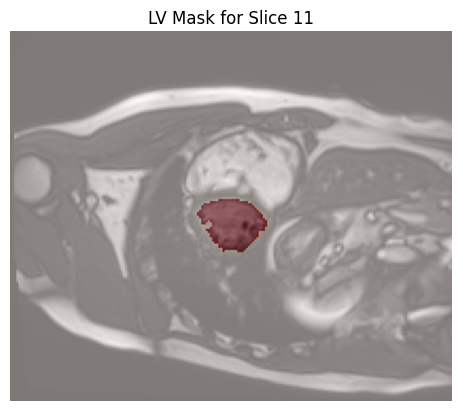

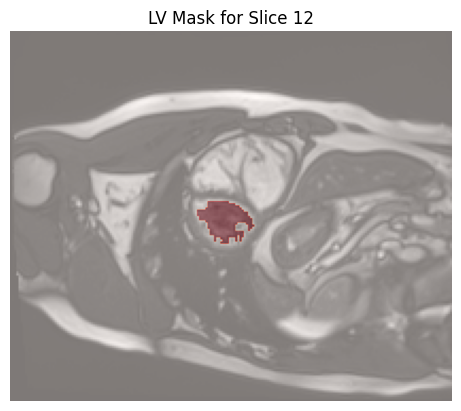

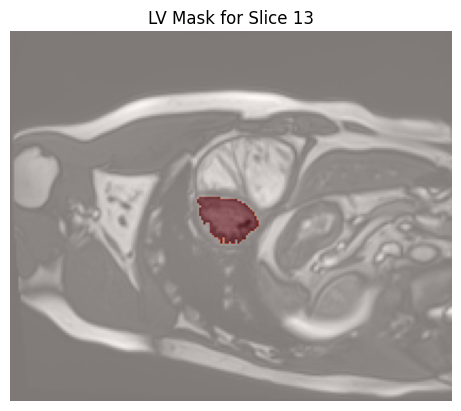

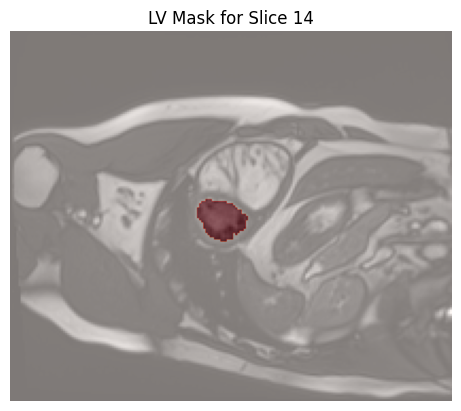

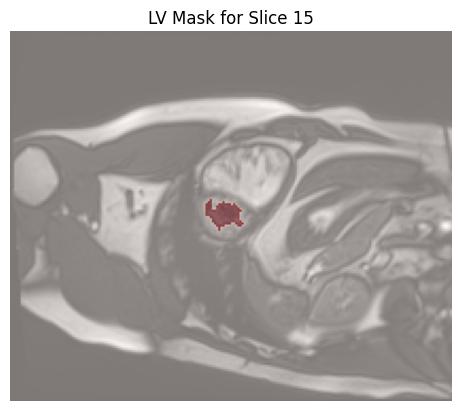

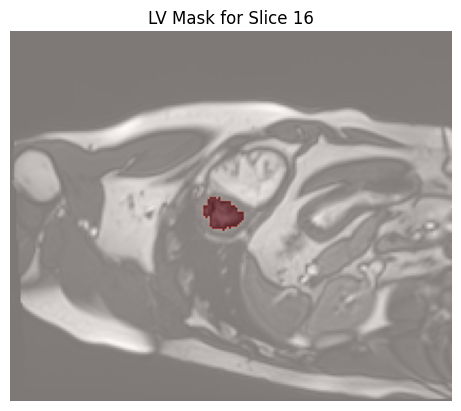

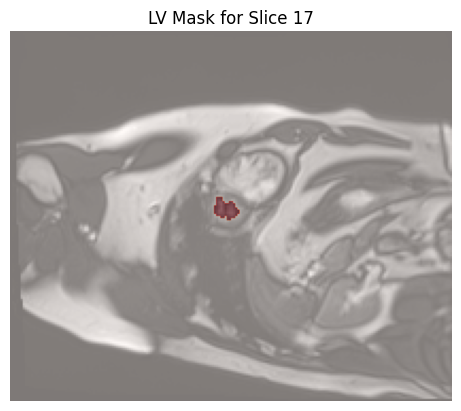

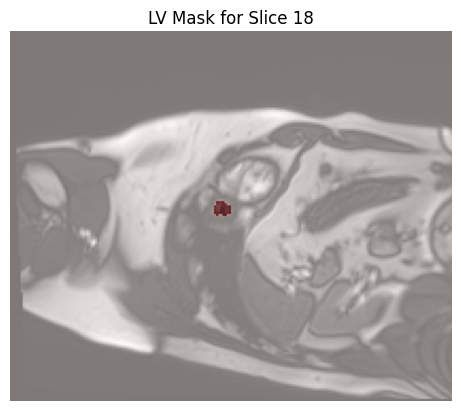

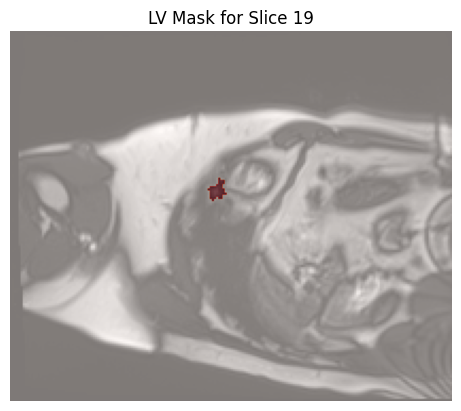

In [14]:
# Plot all masks
for i in range(len(all_masks)):
    plt.imshow(data_ED[:, :, i], cmap='gray')  
    plt.imshow(all_masks[i], cmap='Reds', alpha=0.5)  
    
    plt.title(f"LV Mask for Slice {i}")
    plt.axis('off')
    plt.show()

#### Final usage

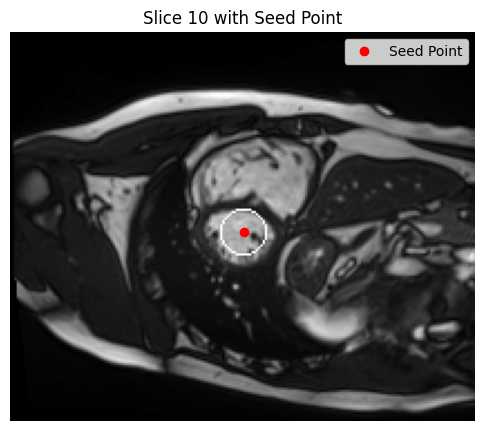

In [15]:
case_id = 118

img_ED = nib.load(f'Dataset/Test/{case_id}/{case_id}_ED.nii')
img_ES = nib.load(f'Dataset/Test/{case_id}/{case_id}_ES.nii')

data_ED = img_ED.get_fdata()
data_ES = img_ES.get_fdata()

slice_idx, circles = compute_seeds(data_ED, data_ES)
seed = select_lowest_circle(circles)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, 10)

slice_img = data_ED[:, :, slice_idx]
max_diff = 30
mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = 30)
while leaked:
    max_diff -= 5
    if max_diff < 0:
        break
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = max_diff)

corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
corrected_slice = normalize_image(corrected_slice)

thresholds = [0, 10]
for i in range(2, 10):
    thresholds.append(thresholds[i-1] + 5)
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds, plot=False)

mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)

num_slices = data_ED.shape[2]
all_masks = [None] * num_slices
all_masks[slice_idx] = mask

propagate_seed_recursive(data_ED, slice_idx + 1, slice_idx, all_masks[slice_idx], all_masks)
propagate_seed_recursive(data_ED, slice_idx - 1, slice_idx, all_masks[slice_idx], all_masks)

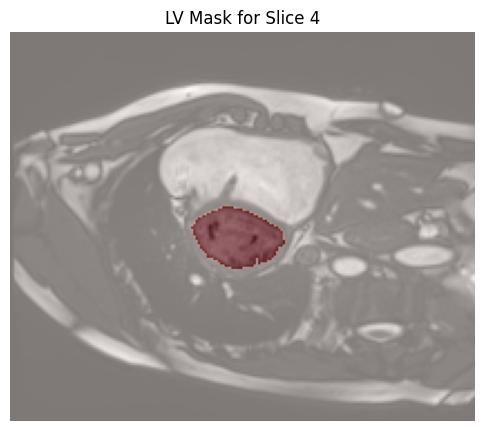

In [16]:
slice_idx = 4  
plt.figure(figsize=(6, 6))
plt.imshow(data_ED[:, :, slice_idx], cmap='gray') 
plt.imshow(all_masks[slice_idx], cmap='Reds', alpha=0.5)  
plt.title(f"LV Mask for Slice {slice_idx}")
plt.axis('off')
plt.show()

#### Evaluation

In [1]:
case_id = 49
case_id = str(case_id).zfill(3)

img_ED = nib.load(f'Dataset/Train/{case_id}/{case_id}_ED.nii')
img_ES = nib.load(f'Dataset/Train/{case_id}/{case_id}_ES.nii')

data_ED = img_ED.get_fdata()
data_ES = img_ES.get_fdata()

slice_idx, circles = compute_seeds(data_ED, data_ES)
seed = select_lowest_circle(circles)
plot_heart_slice_with_seed(data_ED, slice_idx, seed, 10)

slice_img = data_ED[:, :, slice_idx]
max_diff = 30
mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = 30)
while leaked:
    max_diff -= 5
    if max_diff < 0:
        break
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff = max_diff)

corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
corrected_slice = normalize_image(corrected_slice)

thresholds = [0, 10]
for i in range(2, 10):
    thresholds.append(thresholds[i-1] + 5)
lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds, plot=False)

mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean+lv_std)

num_slices = data_ED.shape[2]
all_masks = [None] * num_slices
all_masks[slice_idx] = mask

propagate_seed_recursive(data_ED, slice_idx + 1, slice_idx, all_masks[slice_idx], all_masks, plot=False)
propagate_seed_recursive(data_ED, slice_idx - 1, slice_idx, all_masks[slice_idx], all_masks, plot=False)


NameError: name 'nib' is not defined

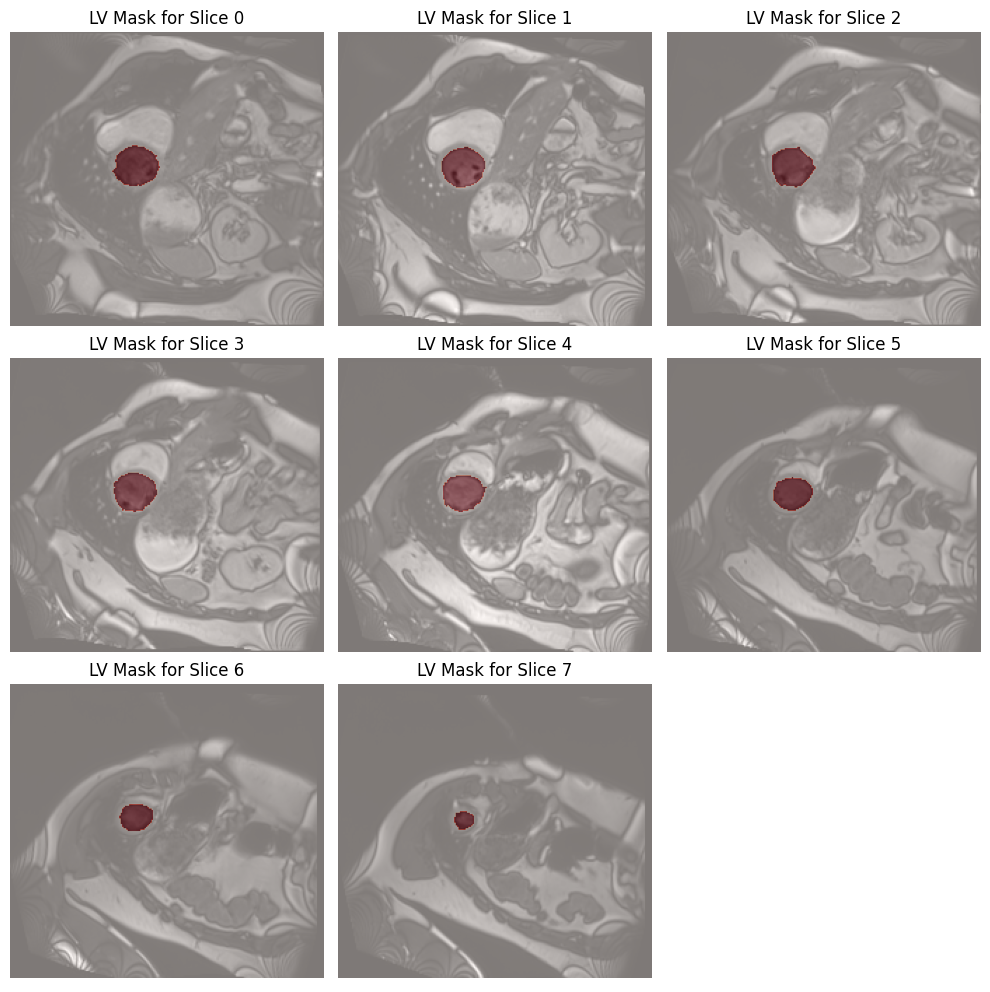

In [18]:
n_images = len(all_masks)
n_cols = 3  # You can adjust this based on your preference
n_rows = (n_images // n_cols) + (1 if n_images % n_cols != 0 else 0)

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the axes array to make it easier to iterate over (if it's a 2D array)
axes = axes.flatten()

# Plot each image in the corresponding subplot
for i in range(n_images):
    axes[i].imshow(data_ED[:, :, i], cmap='gray')  # Original image in grayscale
    axes[i].imshow(all_masks[i], cmap='Reds', alpha=0.5)  # Overlay the mask in red
    axes[i].set_title(f"LV Mask for Slice {i}")
    axes[i].axis('off')  # Hide the axes

# Hide any unused subplots (if there are more subplots than images)
for i in range(n_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Ground truth masks
img_ED_seg = nib.load(f'Dataset/Train/{case_id}/{case_id}_ED_seg.nii')
img_ES_seg = nib.load(f'Dataset/Train/{case_id}/{case_id}_ES_seg.nii')
data_ED_seg = img_ED_seg.get_fdata()
data_ES_seg = img_ES_seg.get_fdata()

all_masks_gt = [None] * num_slices

for i in range(num_slices):
    seg = data_ED_seg[:, :, i]
    # The gt mask is where seg is 3
    all_masks_gt[i] = (seg == 3).astype(np.uint8)

In [20]:
# Evaluate the segmentation using Dice coefficient

def dice_coefficient(predicted_mask, ground_truth_mask):
    """
    Compute the Dice coefficient between two binary masks.

    Parameters:
    - predicted_mask: 2D numpy array representing the predicted mask.
    - ground_truth_mask: 2D numpy array representing the ground truth mask.

    Returns:
    - dice: Dice coefficient value.
    """
    intersection = np.sum(predicted_mask * ground_truth_mask)
    return (2.0 * intersection) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))


dice_scores = []
for i in range(num_slices):
    dice = dice_coefficient(all_masks[i], all_masks_gt[i])
    dice_scores.append(dice)
    print(f"Slice {i}: Dice Coefficient = {dice:.4f}")

mean_dice = np.mean(dice_scores)
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

Slice 0: Dice Coefficient = 0.9538
Slice 1: Dice Coefficient = 0.9688
Slice 2: Dice Coefficient = 0.9354
Slice 3: Dice Coefficient = 0.9572
Slice 4: Dice Coefficient = 0.9576
Slice 5: Dice Coefficient = 0.9701
Slice 6: Dice Coefficient = 0.9661
Slice 7: Dice Coefficient = 0.9481
Mean Dice Coefficient: 0.9571


In [21]:
# Function to evaluate segmentation performance

def evaluate_segmentation(case_id):
    """
    Evaluate the segmentation performance for a given case ID.

    Parameters:
    - case_id: ID of the case to evaluate.
    """

    case_id = str(case_id).zfill(3)
    # Load images
    img_ED = nib.load(f'Dataset/Train/{case_id}/{case_id}_ED.nii')
    img_ES = nib.load(f'Dataset/Train/{case_id}/{case_id}_ES.nii')
    data_ED = img_ED.get_fdata()
    data_ES = img_ES.get_fdata()

    # Compute seeds
    slice_idx, circles = compute_seeds(data_ED, data_ES)
    seed = select_lowest_circle(circles)

    # Segment LV region
    slice_img = data_ED[:, :, slice_idx]
    mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff=30)
    max_diff = 30
    while leaked:
        max_diff -= 5
        if max_diff < 0:
            break
        mask, lv_mean, lv_std, leaked = region_growing_from_seed(slice_img, seed, max_diff=max_diff)

    corrected_slice, bias_plane = compensate_coil_sensitivity(slice_img, mask)
    corrected_slice = normalize_image(corrected_slice)

    # Define thresholds
    thresholds = [0, 10]
    for i in range(2, 10):
        thresholds.append(thresholds[i-1] + 5)

    # Estimate myocardium mean and std using adaptive histogram equalization
    lv_mask, lv_mean, lv_std, myoc_mean, myoc_std, masks = estimate_myocardium_mean(corrected_slice, seed, thresholds)

    # Apply absolute thresholding to obtain final LV mask
    final_lv_mask = abs_threshold_region_growing(corrected_slice, seed, myoc_mean + lv_std)

    # Propagate seed recursively to adjacent slices
    num_slices = data_ED.shape[2]
    all_masks = [None] * num_slices
    all_masks[slice_idx] = final_lv_mask

    propagate_seed_recursive(data_ED, slice_idx + 1, slice_idx, all_masks[slice_idx], all_masks)
    propagate_seed_recursive(data_ED, slice_idx - 1, slice_idx, all_masks[slice_idx], all_masks)

    # Load ground truth masks
    img_ED_seg = nib.load(f'Dataset/Train/{case_id}/{case_id}_ED_seg.nii')
    img_ES_seg = nib.load(f'Dataset/Train/{case_id}/{case_id}_ES_seg.nii')
    data_ED_seg = img_ED_seg.get_fdata()
    data_ES_seg = img_ES_seg.get_fdata()

    all_masks_gt = [None] * num_slices
    for i in range(num_slices):
        seg = data_ED_seg[:, :, i]
        all_masks_gt[i] = (seg == 3).astype(np.uint8)

    # Evaluate segmentation using Dice coefficient
    dice_scores = []
    for i in range(num_slices):
        dice = dice_coefficient(all_masks[i], all_masks_gt[i])
        dice_scores.append(dice)
        print(f"Slice {i}: Dice Coefficient = {dice:.4f}")
    mean_dice = np.mean(dice_scores)
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    return

In [22]:
evaluate_segmentation(49)

Exploded! Region too large
Exploded! Region too large
Exploded! Region too large
Slice 0: Dice Coefficient = 0.0000
Slice 1: Dice Coefficient = 0.0000
Slice 2: Dice Coefficient = 0.0000
Slice 3: Dice Coefficient = 0.0000
Slice 4: Dice Coefficient = 0.0000
Slice 5: Dice Coefficient = 0.0000
Slice 6: Dice Coefficient = 0.0000
Mean Dice Coefficient: 0.0000
